In [1]:
# Generic ones
import numpy as np
import pandas as pd
import os

# Word processing libraries
import re
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# Widen the size of each cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import glob
import gzip

# dfs=[]
data = None
total_count=0
keywords_str='#chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu|#communistvirus|#wuhancoronavirus|#coronajihad'
print('filtering by:', keywords_str)

for file in glob.glob("E:\\Projects\\twitter_covid\\2020-03\\*.gz"):
#     print(file)
    df = pd.read_json(path_or_buf=file, lines=True, compression='infer')
#     print('Read. Size: ', df.shape)
    
    total_count+=df.shape[0]
    df = df[df['full_text'].str.contains("(?i)"+keywords_str)]
    df.reset_index(inplace = True, drop = True)
    if data is None:
        data = df
    else:
        data = pd.concat([data, df], axis = 0)
        # Reset_index
        data.reset_index(inplace = True, drop = True)
        
data_orig=data.copy()

print('Size of dataset before filtering:', total_count)
print('Size of dataset after filtering:', data.shape[0])



filtering by: #chinavirus|#wuhanvirus|#chopstickflu|#kungfuvirus|#chinesevirus|#kungflu|#communistvirus|#wuhancoronavirus|#coronajihad
Size of dataset before filtering: 2962836
Size of dataset after filtering: 5540


In [3]:
data['hashtags'] = data['entities'].apply(lambda x: x['hashtags'])
data['hashtags'].head(3)

0    [{'text': 'WuhanCoronavirus', 'indices': [39, ...
1    [{'text': 'coronavirus', 'indices': [88, 100]}...
2    [{'text': 'coronavirus', 'indices': [58, 70]},...
Name: hashtags, dtype: object

In [4]:
# Remove empty tweets
data.dropna(subset = ['full_text'], inplace = True)
# The unicode accounts for Chinese characters and punctuations.
def strip_chinese_words(string):
    # list of english words
    en_list = re.findall(u'[^\u4E00-\u9FA5\u3000-\u303F]', str(string))
    
    # Remove word from the list, if not english
    for c in string:
        if c not in en_list:
            string = string.replace(c, '')
    return string
# Apply strip_chinese_words(...) on the column 'text'
data['full_text'] = data['full_text'].apply(lambda x: strip_chinese_words(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags
0,2020-03-02 09:06:28+00:00,1234404698515361793,1234404698515361792,RT @sidhant: India confirms 2 cases of #WuhanC...,False,"[0, 56]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,NaN,en,{'created_at': 'Mon Mar 02 08:54:50 +0000 2020...,NaN,NaN,NaN,"[{'text': 'WuhanCoronavirus', 'indices': [39, ..."
1,2020-03-02 09:07:09+00:00,1234404869731213312,1234404869731213312,RT @CellosSuits: European Union\n\n- Nike temp...,False,"[0, 140]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://twitter.com/FreeBet13"" rel=""n...",NaN,...,0,False,False,NaN,en,{'created_at': 'Mon Mar 02 08:57:46 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [88, 100]}..."
2,2020-03-02 09:07:34+00:00,1234404974756421632,1234404974756421632,Britain\n\n- Health worker at cancer centre am...,False,"[0, 278]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,0.0,en,NaN,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [58, 70]},..."
3,2020-03-02 09:08:36+00:00,1234405232936833024,1234405232936833024,RT @snowemoji123: #WuhanCoronavirus\n#coronavi...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,NaN,zh,{'created_at': 'Mon Mar 02 06:29:19 +0000 2020...,NaN,NaN,NaN,"[{'text': 'WuhanCoronavirus', 'indices': [18, ..."
4,2020-03-02 09:08:40+00:00,1234405249454002176,1234405249454002176,So if China eradicates the #KUNGFLU and then c...,False,"[0, 110]","{'hashtags': [{'text': 'KUNGFLU', 'indices': [...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,NaN,en,NaN,NaN,NaN,NaN,"[{'text': 'KUNGFLU', 'indices': [27, 35]}]"


In [5]:
# Define function to sieve out @users in a tweet:
def mentioned_users(string):
    usernames = re.findall('@[^\s]+', string)
    return usernames
# Create a new column and apply the function on the column 'text'
data['mentioned_users'] = data['full_text'].apply(lambda x: mentioned_users(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags,mentioned_users
0,2020-03-02 09:06:28+00:00,1234404698515361793,1234404698515361792,RT @sidhant: India confirms 2 cases of #WuhanC...,False,"[0, 56]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,en,{'created_at': 'Mon Mar 02 08:54:50 +0000 2020...,NaN,NaN,NaN,"[{'text': 'WuhanCoronavirus', 'indices': [39, ...",[@sidhant:]
1,2020-03-02 09:07:09+00:00,1234404869731213312,1234404869731213312,RT @CellosSuits: European Union\n\n- Nike temp...,False,"[0, 140]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://twitter.com/FreeBet13"" rel=""n...",NaN,...,False,False,NaN,en,{'created_at': 'Mon Mar 02 08:57:46 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [88, 100]}...",[@CellosSuits:]
2,2020-03-02 09:07:34+00:00,1234404974756421632,1234404974756421632,Britain\n\n- Health worker at cancer centre am...,False,"[0, 278]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,False,False,0.0,en,NaN,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [58, 70]},...",[@Telegraph]
3,2020-03-02 09:08:36+00:00,1234405232936833024,1234405232936833024,RT @snowemoji123: #WuhanCoronavirus\n#coronavi...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,zh,{'created_at': 'Mon Mar 02 06:29:19 +0000 2020...,NaN,NaN,NaN,"[{'text': 'WuhanCoronavirus', 'indices': [18, ...",[@snowemoji123:]
4,2020-03-02 09:08:40+00:00,1234405249454002176,1234405249454002176,So if China eradicates the #KUNGFLU and then c...,False,"[0, 110]","{'hashtags': [{'text': 'KUNGFLU', 'indices': [...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,False,False,NaN,en,NaN,NaN,NaN,NaN,"[{'text': 'KUNGFLU', 'indices': [27, 35]}]",[]


In [6]:
# Define Emoji_patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
# Define the function to implement POS tagging:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Define the main function to clean text in various ways:
def clean_text(text):
    
    # Apply regex expressions first before converting string to list of tokens/words:
    # 1. remove @usernames
    text = re.sub('@[^\s]+', '', text)
    
    # 2. remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    
    # 3. remove hashtags entirely i.e. #hashtags
    text = re.sub(r'#([^\s]+)', '', text)
    
    # 4. remove emojis
    text = emoji_pattern.sub(r'', text)
    
    # 5. Convert text to lowercase
    text = text.lower()
    
    # 6. tokenise text and remove punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # 7. remove numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # 8. remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # 9. remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # 10. pos tag text and lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # 11. remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    
    return(text)
# Apply function on the column 'text':
data['cleaned_text'] = data['full_text'].apply(lambda x: clean_text(x))
data.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries,withheld_scope,withheld_copyright,hashtags,mentioned_users,cleaned_text
0,2020-03-02 09:06:28+00:00,1234404698515361793,1234404698515361792,RT @sidhant: India confirms 2 cases of #WuhanC...,False,"[0, 56]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,en,{'created_at': 'Mon Mar 02 08:54:50 +0000 2020...,NaN,NaN,NaN,"[{'text': 'WuhanCoronavirus', 'indices': [39, ...",[@sidhant:],rt india confirm case
1,2020-03-02 09:07:09+00:00,1234404869731213312,1234404869731213312,RT @CellosSuits: European Union\n\n- Nike temp...,False,"[0, 140]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://twitter.com/FreeBet13"" rel=""n...",NaN,...,False,NaN,en,{'created_at': 'Mon Mar 02 08:57:46 +0000 2020...,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [88, 100]}...",[@CellosSuits:],rt european union\n\n nike temporarily close e...
2,2020-03-02 09:07:34+00:00,1234404974756421632,1234404974756421632,Britain\n\n- Health worker at cancer centre am...,False,"[0, 278]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,False,0.0,en,NaN,NaN,NaN,NaN,"[{'text': 'coronavirus', 'indices': [58, 70]},...",[@Telegraph],britain\n\n health worker cancer centre among ...
3,2020-03-02 09:08:36+00:00,1234405232936833024,1234405232936833024,RT @snowemoji123: #WuhanCoronavirus\n#coronavi...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,NaN,zh,{'created_at': 'Mon Mar 02 06:29:19 +0000 2020...,NaN,NaN,NaN,"[{'text': 'WuhanCoronavirus', 'indices': [18, ...",[@snowemoji123:],rt \n\n\nsnow‼‼‼ ‼‼\n
4,2020-03-02 09:08:40+00:00,1234405249454002176,1234405249454002176,So if China eradicates the #KUNGFLU and then c...,False,"[0, 110]","{'hashtags': [{'text': 'KUNGFLU', 'indices': [...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,False,NaN,en,NaN,NaN,NaN,NaN,"[{'text': 'KUNGFLU', 'indices': [27, 35]}]",[],china eradicate close border rest world would ...


In [7]:
# Define a function to perform this extraction:
def extract_hashtags(hashtag_list):
    # argument:
    # hashtag_list - a list of dictionary(ies), each containing a hashtag
    
    # Create a list to store the hashtags
    hashtags = []
    if isinstance(hashtag_list, float):
        hashtag_list=[]
    
    # Loop through the list:
    for i in range(0, len(hashtag_list)):
        # extract the hashtag value using the key - 'text'
        # For our purposes, we can ignore the indices, which tell us the position of the hashtags in the string of tweet
        # lowercase the text as well
        hashtags.append(hashtag_list[i]['text'].lower())
        
    return hashtags
# Apply function on the column - data['hashtags']
data['hashtags'] = data['hashtags'].apply(lambda x: extract_hashtags(x))
# Check out the updated column 'hashtags'
print(data.head()['hashtags'])

0                                   [wuhancoronavirus]
1                 [coronavirus, covid2019, chinavirus]
2    [coronavirus, covid2019, chinavirus, chinacoro...
3                      [wuhancoronavirus, coronavirus]
4                                            [kungflu]
Name: hashtags, dtype: object


In [8]:
#Show hashtags
        
data[data['hashtags'].apply(lambda x: True if len(x)>0 else False)]['hashtags']

0                                      [wuhancoronavirus]
1                    [coronavirus, covid2019, chinavirus]
2       [coronavirus, covid2019, chinavirus, chinacoro...
3                         [wuhancoronavirus, coronavirus]
4                                               [kungflu]
                              ...                        
5535                                   [wuhancoronavirus]
5536                                            [kungflu]
5537                                     [chinesevirus19]
5538                                         [chinavirus]
5539    [nizamuddinmarkaj, coronavirusindia, coronajih...
Name: hashtags, Length: 5532, dtype: object

In [9]:
data['location'] = df.user.apply(lambda x: x['location'])
data['acctdesc'] = df.user.apply(lambda x: x['description'])
data[['location','acctdesc']].head(3)

,location,acctdesc
0,"Hyderabad, India",HINDU
1,,
2,"San Cristóbal, Edo. Táchira",Conservador. Fundador del Movimiento Civil Con...


In [10]:
# Replace NaN (empty) values with n.a to indicate that the user did not state his location
# Define a function to handle this:
def remove_nan(text):
    if pd.isnull(text) == True: # entry is NaN
        text = 'n.a'
    else:
        # lowercase text for possible easy handling
        text = text.lower()
        
    return text
# Apply function on column - data['location']
data['location'] = data['location'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['location'])
# Let's take a quick look at the value_counts()
data['location'].value_counts()

0               hyderabad, india
1                               
2    san cristóbal, edo. táchira
3                tokyo-to, japan
4                               
Name: location, dtype: object


n.a                       5422
                            33
india                        8
united states                4
new delhi, india             2
                          ... 
england                      1
long island, new york        1
bangalore, guwahati          1
buena park, ca               1
egypt                        1
Name: location, Length: 74, dtype: int64

In [11]:
# Apply the function already defined above: remove_nan(...)
# Apply function on column - data['acctdesc']
data['acctdesc'] = data['acctdesc'].apply(lambda x: remove_nan(x))
# Check out the updated columns
print(data.head()['acctdesc'])

0                                                hindu
1                                                     
2    conservador. fundador del movimiento civil con...
3    🌈emperors🍀buddha🧘‍♀️zen spirit 🇯🇵pm abe🇺🇸pres....
4                                               prince
Name: acctdesc, dtype: object


In [12]:
# Importing VADER from NLTK
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Create a sid object called SentimentIntensityAnalyzer()
sid = SentimentIntensityAnalyzer()
# Apply polarity_score method of SentimentIntensityAnalyzer()
data['sentiment'] = data['cleaned_text'].apply(lambda x: sid.polarity_scores(x))
# Keep only the compound scores under the column 'Sentiment'
data = pd.concat([data.drop(['sentiment'], axis = 1), data['sentiment'].apply(pd.Series)], axis = 1)

In [13]:
# New column: number of characters in 'review'
data['numchars'] = data['cleaned_text'].apply(lambda x: len(x))
# New column: number of words in 'review'
data['numwords'] = data['cleaned_text'].apply(lambda x: len(x.split(" ")))
# Check the new columns:
data.tail(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,mentioned_users,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords
5538,2020-03-31 16:55:41+00:00,1245032027981852673,1245032027981852672,RT @PercyGoneWild: @JordanSchachtel and statis...,False,"[0, 130]","{'hashtags': [{'text': 'chinavirus', 'indices'...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,"[@PercyGoneWild:, @JordanSchachtel]",rt statistically look lethal bad flu,n.a,n.a,0.604,0.396,0.000,-0.7269,36,6
5539,2020-03-31 16:55:45+00:00,1245032044452696065,1245032044452696064,"It is matter of investigation, whether these #...",False,"[0, 226]","{'hashtags': [{'text': 'NizamuddinMarkaj', 'in...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,"[@PMOIndia, @HMOIndia]",matter investigation whether deliberately spre...,n.a,n.a,0.000,0.845,0.155,0.0258,74,8


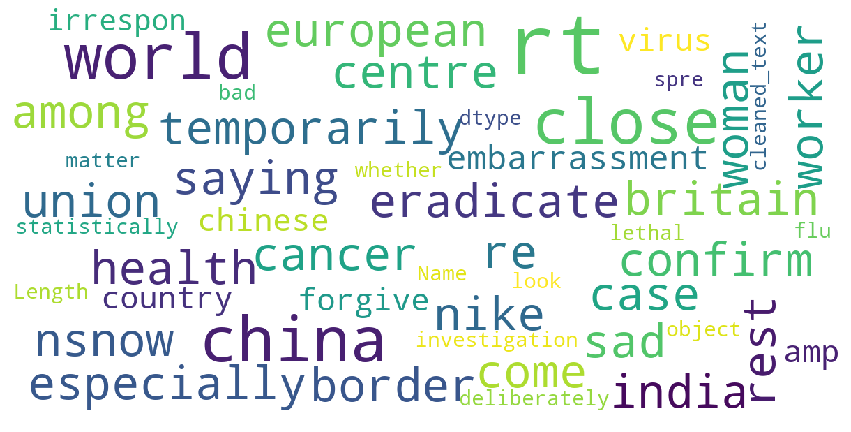

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data['cleaned_text'])

In [15]:
# the column data['hashtags'] returns a list of string(s) for each tweet. Build a list of all hashtags in the dataset.
hashtag_list = []
for i in range(0, len(data)):
    # Obtain the current list of hashtags
    curr_hashtag = data.iloc[i, :]['hashtags']
    
    # Extract and append the hashtags to 'hashtag_list':
    for j in range(0, len(curr_hashtag)):
        hashtag_list.append(curr_hashtag[j])
        
# No. of hashtags
print('No. of hashtags used in {} tweets is {}'.format(len(data), len(hashtag_list)))

df_hashtag = pd.DataFrame(
    {'hashtags': hashtag_list}
)
print(df_hashtag.head(20))
print('Shape of df_hashtag is:', df_hashtag.shape)

No. of hashtags used in 5540 tweets is 15995
               hashtags
0      wuhancoronavirus
1           coronavirus
2             covid2019
3            chinavirus
4           coronavirus
5             covid2019
6            chinavirus
7      chinacoronavirus
8   coronavirusoutbreak
9         coronavirusuk
10    coronavirusitalia
11    coronavirusespaña
12       coronavirususa
13    coronavirusupdate
14     wuhancoronavirus
15          coronavirus
16              kungflu
17     wuhancoronavirus
18     wuhancoronavirus
19                 psca
Shape of df_hashtag is: (15995, 1)


                      hashtags  counts
412               chinesevirus    2052
366                 chinavirus    1176
2173          wuhancoronavirus    1166
2192                wuhanvirus    1038
413             chinesevirus19     800
550                coronavirus     690
646                    covid19     481
303                      china     398
2165                     wuhan     374
339        chinaliedpeopledied     235
678                  covid2019     166
598        coronavirusoutbreak     152
1263                   kungflu     123
686                   covid_19     111
262                        ccp     105
2175  wuhancoronavirusoutbreak     100
416         chineseviruscorona      99
695                   covidー19      97
273                   ccpvirus      91
314           chinacoronavirus      88
422          chinesewuhanvirus      79
507                     corona      75
392         chinesecoronavirus      74
335     chinaliedandpeopledied      67
1563                    p

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32954 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from c

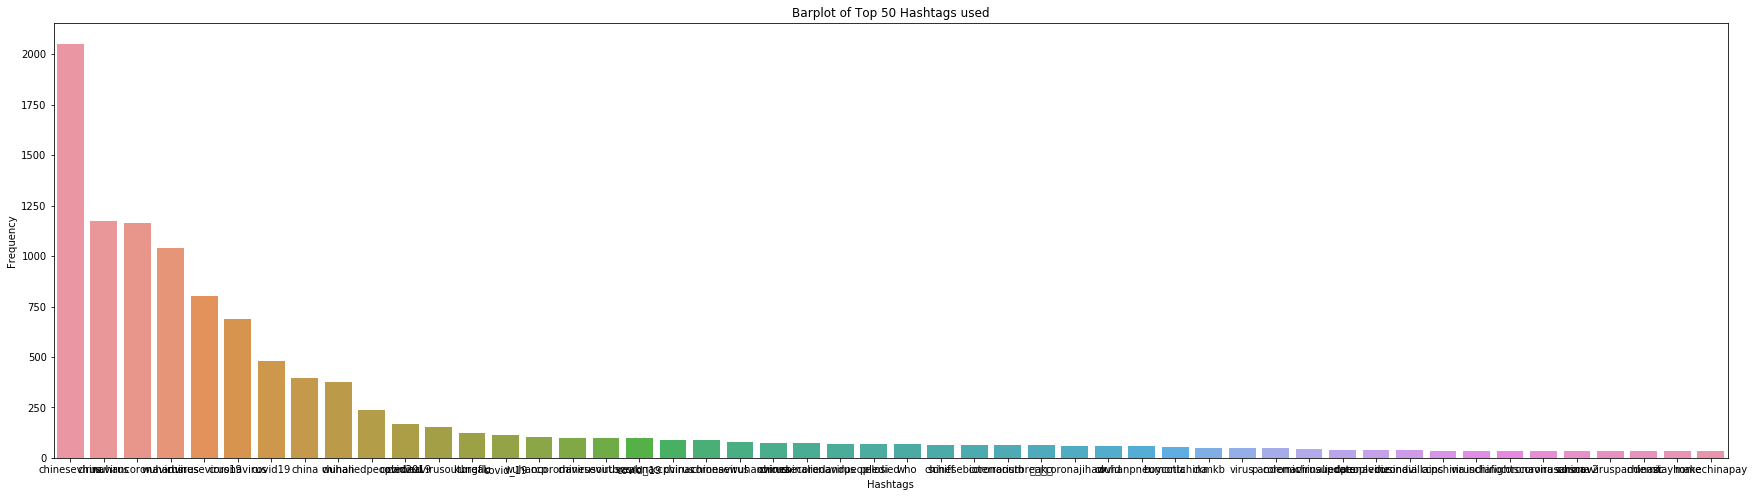

In [16]:
import seaborn as sns

# Define N to be the top number of hashtags
N = 50
top_hashtags = df_hashtag.groupby(['hashtags']).size().reset_index(name = 'counts').sort_values(by = 'counts', ascending = False).head(N)
print(top_hashtags)
# seaborn countplot on the top N hashtags
plt.figure(figsize=(30,8))
sns.set_palette('PuBuGn_d')
sns.barplot(x = 'hashtags', y = 'counts', data = top_hashtags[:10])
plt.title('Barplot of Top ' + str(10) + ' Hashtags used')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.show()

In [17]:
def isNaN(num):
    return num != num

def get_full_name(x):
    if x is None or isNaN(x):
        return None
    else:
        return x['full_name']
data['place_full_name']=data['place'].apply(lambda x: get_full_name(x))

data[data['place_full_name'].apply(lambda x: x is not None)]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
12,2020-03-02 09:53:18+00:00,1234416483213639685,1234416483213639680,2.30 PM was the moment around which Markets go...,False,"[0, 183]","{'hashtags': [{'text': 'WuhanCoronavirus', 'in...","{'media': [{'id': 1234416473201922059, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,pm moment around market get know confirm case ...,planet x,parody account of world's best bc cm.i am best...,0.209,0.791,0.000,-0.5719,92,15,"New Delhi, India"
85,2020-03-03 12:55:00+00:00,1234824597033242624,1234824597033242624,"I never thought our death would be also be "" M...",False,"[0, 165]","{'hashtags': [{'text': 'ChinaCoronaVirus', 'in...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,"never think death would also make china,""\n","westlake, oh",,0.000,0.656,0.344,0.4847,42,7,"Panchkula, India"
143,2020-03-03 19:58:52+00:00,1234931267944271872,1234931267944271872,Short cilp of official song of Corona virus si...,False,"[0, 203]",{'hashtags': [{'text': 'CoronavirusReachesDelh...,"{'media': [{'id': 1234931143981572099, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,short cilp official song corona virus sindhi v...,n.a,n.a,0.000,1.000,0.000,0.0000,55,8,"Sindh, Pakistan"
293,2020-03-04 06:49:31+00:00,1235095008945917954,1235095008945917952,I will now be calling #coronavirus #kungflu,False,"[0, 44]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,call,n.a,n.a,0.000,1.000,0.000,0.0000,4,1,"Los Angeles, CA"
347,2020-03-04 06:08:11+00:00,1235084605469810691,1235084605469810688,Just in: Indian PM Modi not to participate in ...,False,"[0, 113]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,indian pm modi participate holi milan programm...,n.a,n.a,0.000,1.000,0.000,0.0000,61,9,"New Delhi, India"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5339,2020-03-31 15:10:18+00:00,1245005507083096065,1245005507083096064,@China_Amb_India killer China . third class Ch...,False,"[0, 102]","{'hashtags': [{'text': 'ChineseVirusCorona', '...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,killer china third class china criminal china,n.a,n.a,0.606,0.394,0.000,-0.8271,45,7,"Bengaluru South, India"
5340,2020-03-31 15:10:25+00:00,1245005536061526017,1245005536061526016,#ChinaVirus \n#ChinaLiedPeopleDied \n#Whuanvir...,False,"[0, 46]","{'hashtags': [{'text': 'ChinaVirus', 'indices'...","{'media': [{'id': 1245005532223533058, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,,n.a,n.a,0.000,0.000,0.000,0.0000,0,1,"Baripada, India"
5348,2020-03-31 15:11:39+00:00,1245005847023017984,1245005847023017984,#KungFlu #ChinaVirus #NotSorry #COVID19 #Coron...,False,"[0, 141]","{'hashtags': [{'text': 'KungFlu', 'indices': [...","{'media': [{'id': 1245005842447032320, 'id_str...","<a href=""http://twitter.com/download/android"" ...",NaN,...,,n.a,n.a,0.000,0.000,0.000,0.0000,0,1,"Middletown, NY"
5353,2020-03-31 15:12:28+00:00,1245006052430688256,1245006052430688256,You are a radical islamic element.\n#Nizamuddi...,False,"[0, 121]","{'hashtags': [{'text': 'Nizamuddin', 'indices'...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,...,radical islamic element.\n \n\n,n.a,n.a,0.000,1.000,0.000,0.0000,28,4,"New Delhi, India"


In [18]:
data[data['coordinates'].apply(lambda x: x is not None and not isNaN(x))]

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,cleaned_text,location,acctdesc,neg,neu,pos,compound,numchars,numwords,place_full_name
1233,2020-03-16 21:03:34+00:00,1239658591839088640,1239658591839088640,San Francisco is locked down #coronavirus #wuh...,False,"[0, 109]","{'hashtags': [{'text': 'coronavirus', 'indices...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,san francisco lock san francisco california,n.a,n.a,0.0,1.000,0.000,0.0000,43,6,"San Francisco, CA"
3640,2020-03-27 10:04:27+00:00,1243478986476355586,1243478986476355584,#Japanese pen me #Chinese Nib lage hone se #co...,False,"[0, 144]","{'hashtags': [{'text': 'Japanese', 'indices': ...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,pen nib lage hone se failne ki kitni possibili...,n.a,n.a,0.0,1.000,0.000,0.0000,64,12,"New Delhi, India"
4712,2020-03-28 18:31:50+00:00,1243969061521768449,1243969061521768448,Lockdown Day 4 in India STAY HOME AND STAY SAF...,False,"[0, 236]","{'hashtags': [{'text': 'Chinavirus', 'indices'...",NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,...,lockdown day india stay home stay safe wish ev...,n.a,n.a,0.0,0.575,0.425,0.8779,119,19,"New Delhi, India"



Wordcloud for Keyword:  chinesevirus


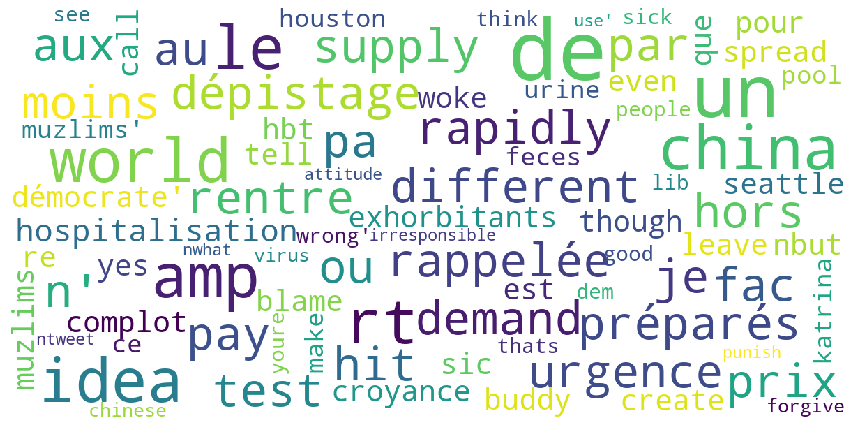


Wordcloud for Keyword:  chinaliedpeopledied


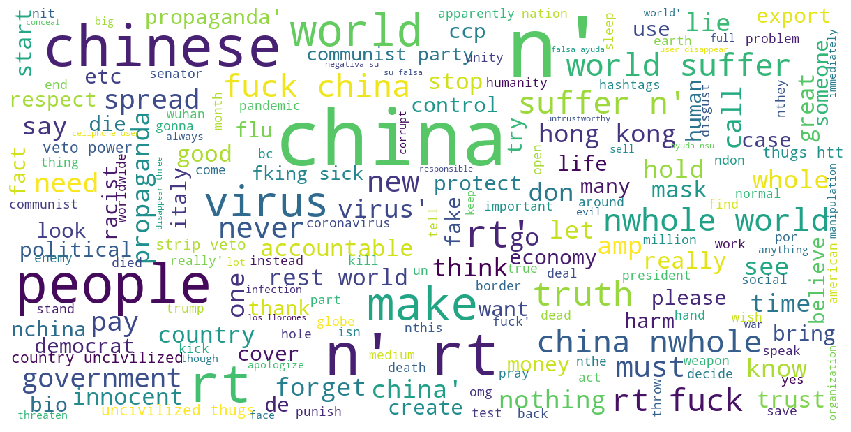


Wordcloud for Keyword:  chinesebioterrorism


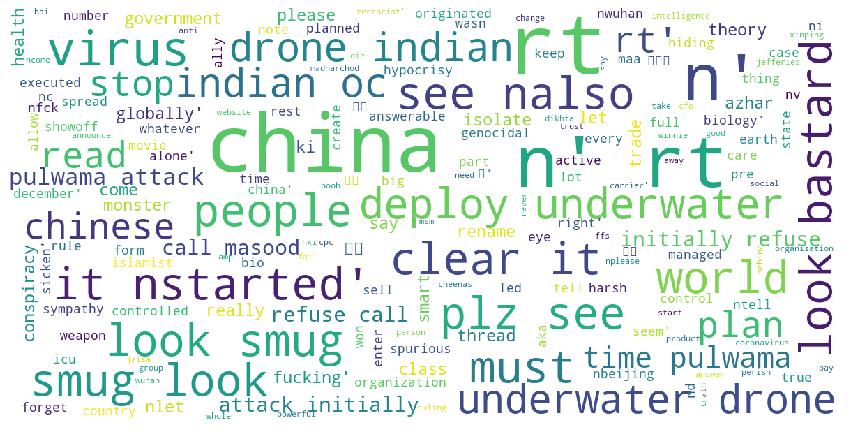


Wordcloud for Keyword:  chinazi


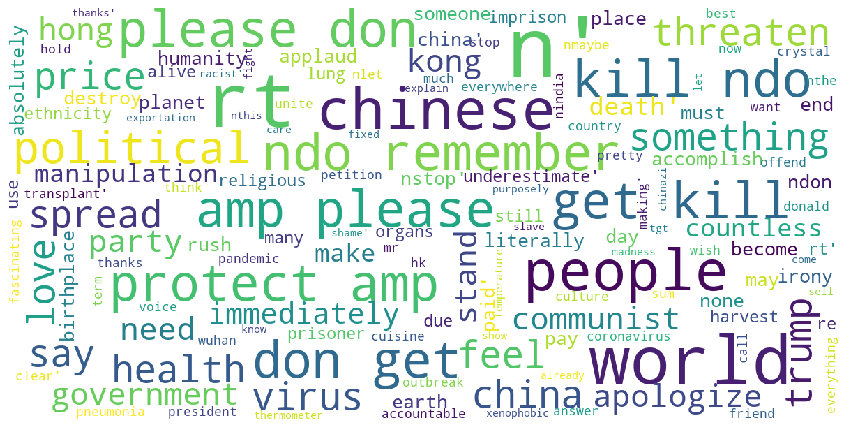

In [19]:
keyword_ts=['chinesevirus','chinaliedpeopledied','chinesebioterrorism','chinazi']
for keyword_t in keyword_ts:
    print('\nWordcloud for Keyword: ', keyword_t)
    df_t = data[data['full_text'].str.contains("(?i)#"+keyword_t)]
    show_wordcloud(df_t['cleaned_text'].values)